,Date,Type,Value,Year,Skupina,Latinica
0,2002-01-01,JELŠA,0.0,2002,Drevesa,Alnus spp.
1,2002-01-02,JELŠA,0.0,2002,Drevesa,Alnus spp.
2,2002-01-03,JELŠA,0.0,2002,Drevesa,Alnus spp.
3,2002-01-04,JELŠA,0.0,2002,Drevesa,Alnus spp.
4,2002-01-05,JELŠA,0.0,2002,Drevesa,Alnus spp.


Type
GABER            7028.0
KOPRIVOVKE       4264.0
PRAVI KOSTANJ    3529.0
JELŠA            2655.0
TRAVE            2652.0
CIPRESOVKE       2387.0
BREZA            2366.0
BOR              1909.0
LESKA            1494.0
JESEN            1491.0
BUKEV            1024.0
HRAST             550.0
PLATANA           477.0
PELIN             468.0
AMBROZIJA         445.0
TRPOTEC           347.0
KISLICA           199.0
OLJKA              98.0
Name: Value, dtype: float64

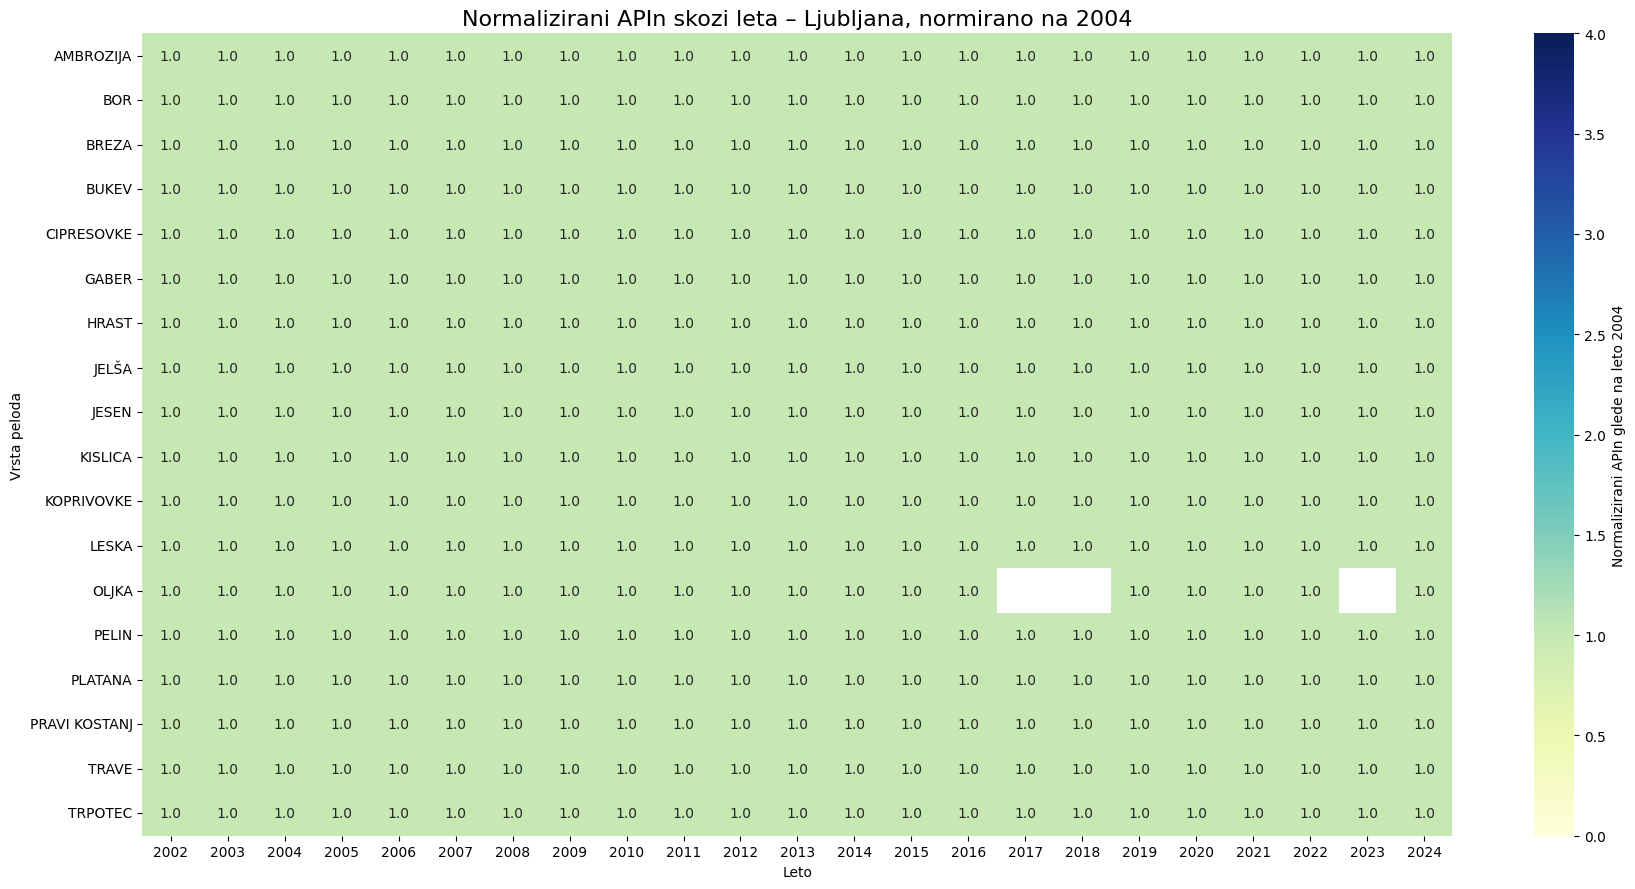

,Date,Type,Value,Year,Skupina,Latinica
0,2002-01-01,JELŠA,0.0,2002,Drevesa,Alnus spp.
1,2002-01-02,JELŠA,0.0,2002,Drevesa,Alnus spp.
2,2002-01-03,JELŠA,0.0,2002,Drevesa,Alnus spp.
3,2002-01-04,JELŠA,0.0,2002,Drevesa,Alnus spp.
4,2002-01-05,JELŠA,0.0,2002,Drevesa,Alnus spp.


Type
KOPRIVOVKE       7511.0
GABER            5147.0
JELŠA            4747.0
PRAVI KOSTANJ    3298.0
BREZA            3239.0
TRAVE            2967.0
BOR              2780.0
CIPRESOVKE       1683.0
LESKA             978.0
AMBROZIJA         959.0
JESEN             927.0
HRAST             888.0
BUKEV             879.0
PELIN             594.0
PLATANA           265.0
TRPOTEC           259.0
KISLICA           159.0
OLJKA              28.0
Name: Value, dtype: float64

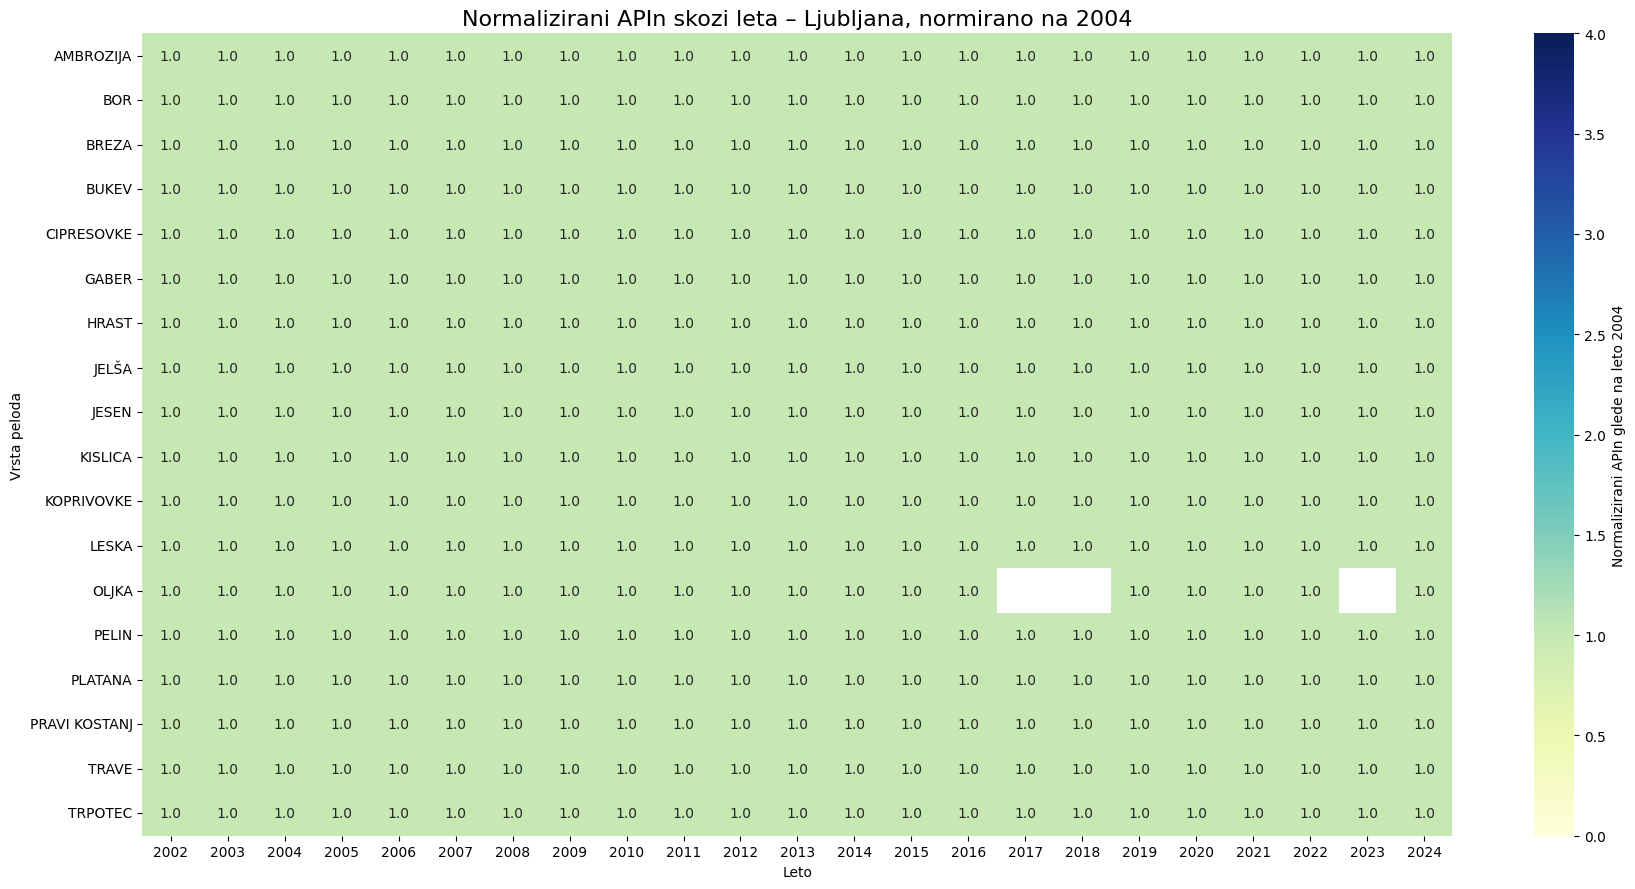

,Date,Type,Value,Year,Skupina,Latinica
0,2002-01-01,JELŠA,0.0,2002,Drevesa,Alnus spp.
1,2002-01-02,JELŠA,0.0,2002,Drevesa,Alnus spp.
2,2002-01-03,JELŠA,0.0,2002,Drevesa,Alnus spp.
3,2002-01-04,JELŠA,0.0,2002,Drevesa,Alnus spp.
4,2002-01-05,JELŠA,0.0,2002,Drevesa,Alnus spp.


Type
CIPRESOVKE       7476.0
GABER            6777.0
KOPRIVOVKE       2214.0
TRAVE            1567.0
BOR              1490.0
OLJKA            1414.0
JESEN            1379.0
PRAVI KOSTANJ    1136.0
JELŠA             764.0
LESKA             599.0
HRAST             585.0
PLATANA           473.0
AMBROZIJA         414.0
BUKEV             286.0
TRPOTEC           214.0
BREZA             167.0
PELIN             131.0
KISLICA            73.0
Name: Value, dtype: float64

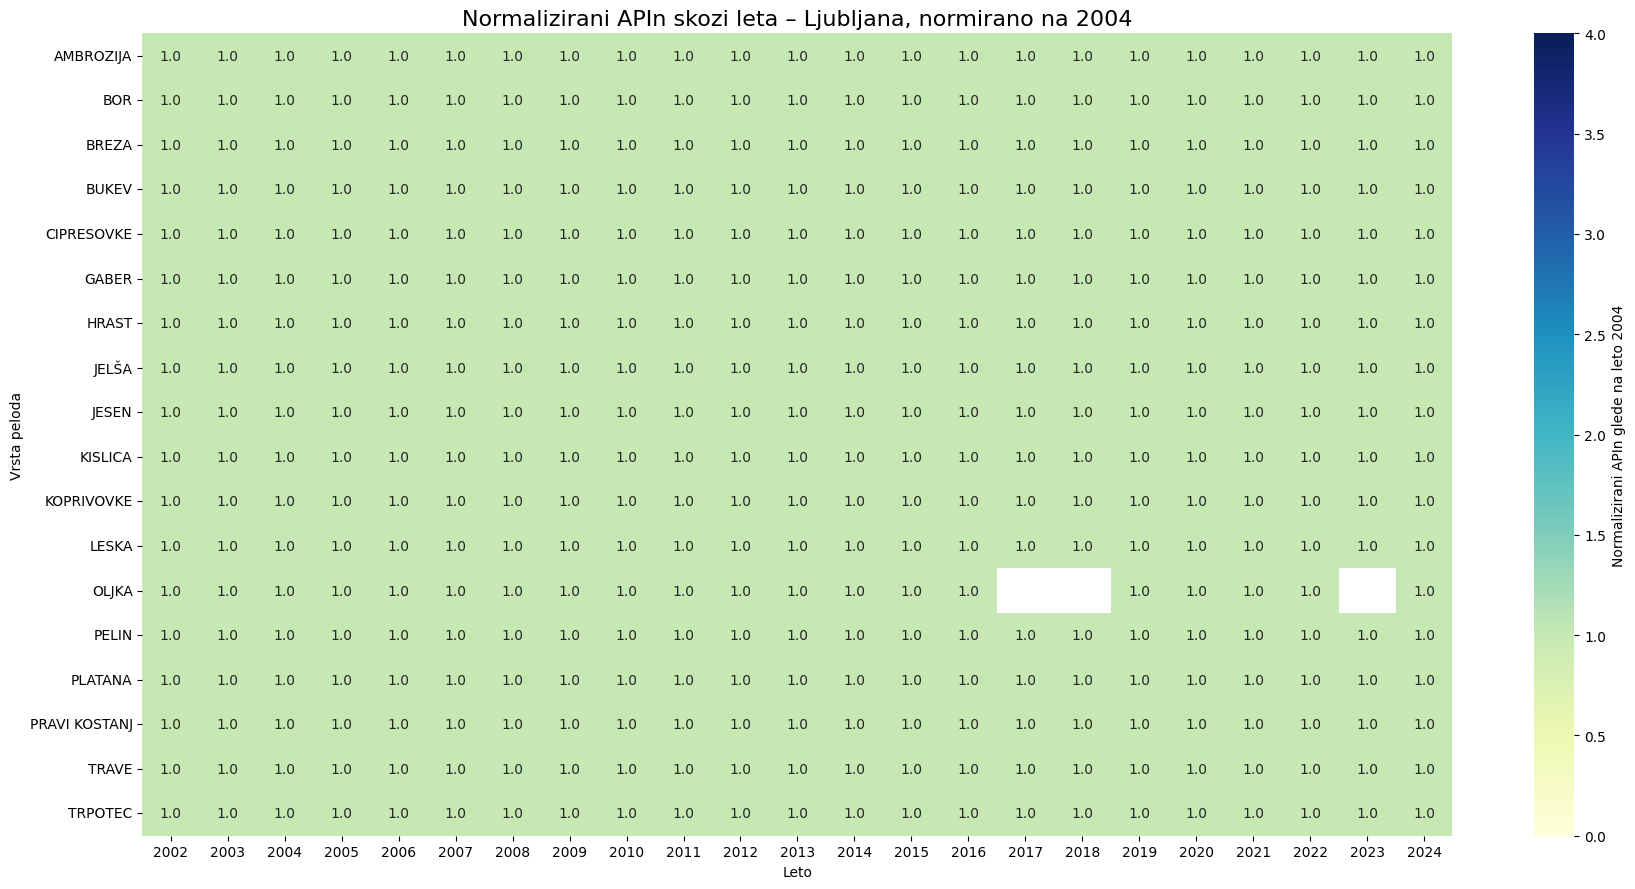

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


location = ["Ljubljana", "Maribor", "Primorje"]
for loc in location:
    path = os.path.join("data", "processed", f"{loc}_processed.csv")

    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    display(df.head())
    df_sum = df.groupby(['Type', 'Year'])['Value'].sum().reset_index()
    ref_year = 2004
    ref_sums = df_sum[df_sum['Year'] == ref_year].set_index('Type')['Value'].sort_values(ascending=False)
    display(ref_sums)
    def norm_to_ref(row):
        ref = ref_sums.get(row['Type'], np.nan)
        return row['Value'] / ref if pd.notnull(ref) and ref != 0 else np.nan

    df_sum['Normalized_APIn'] = df_sum.apply(norm_to_ref, axis=1)
    heatmap_df = df_sum.pivot(index='Type', columns='Year', values='Normalized_APIn')


    path = os.path.join("data", "processed", "Ljubljana_processed.csv")
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # 1. Calculate annual sums
    df_sum = df.groupby(['Type', 'Year'])['Value'].sum().reset_index()

    # 2. Reference year normalization
    ref_year = 2004
    ref_sums = df_sum[df_sum['Year'] == ref_year].set_index('Type')['Value']
    df_sum['Normalized_APIn'] = df_sum.apply(
        lambda row: row['Value'] / ref_sums.get(row['Type'], np.nan) if pd.notnull(ref_sums.get(row['Type'], np.nan)) and ref_sums.get(row['Type'], np.nan) != 0 else np.nan,
        axis=1
    )
    
    # 2.1 Normalite by yearly APIn
    yearly_totals = df_sum.groupby(['Year', 'Type'])['Value'].sum().reset_index()
    yearly_totals = yearly_totals.rename(columns={'Value': 'APIn_Year_Type'})
    df_sum = pd.merge(df_sum, yearly_totals, on=['Year', 'Type'], how='left')

    df_sum['Normalized_APIn'] = df_sum.apply(
        lambda row: row['Value'] / row['APIn_Year_Type'] if row['APIn_Year_Type'] > 0 else np.nan,
        axis=1
    )
    # Na koncu lahko zbrišemo pomožni stolpec APIn_Year_Type
    df_sum = df_sum.drop(columns=['APIn_Year_Type'])

    # 3. Pivot for heatmap
    heatmap_df = df_sum.pivot(index='Type', columns='Year', values='Normalized_APIn')

    # 4. Plot
    plt.figure(figsize=(18, 9))
    ax = sns.heatmap(
        heatmap_df, 
        annot=True, 
        fmt=".1f", 
        cmap="YlGnBu",
        vmax = 4,
        vmin = 0,
        cbar_kws={"label": f"Normalizirani APIn glede na leto {ref_year}"}
    )
    plt.title(f"Normalizirani APIn skozi leta – Ljubljana, normirano na {ref_year}", fontsize=16)
    plt.xlabel("Leto")
    plt.ylabel("Vrsta peloda")
    plt.tight_layout()
    plt.savefig(os.path.join("results", f"{loc}_heatmap_norm_{ref_year}.png"), dpi=300)
    plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns

# Load JSON data from the files containing detailed yearly results (the *_results_2.json files)
files = {
    "Ljubljana": os.path.join("results","Ljubljana_results_2_norm.json"),
    "Maribor": os.path.join("results","Maribor_results_2_norm.json"),
    "Primorje": os.path.join("results","Primorje_results_2_norm.json")
}

data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Pollen taxa", "Year", "Start", "Location"]])
# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)

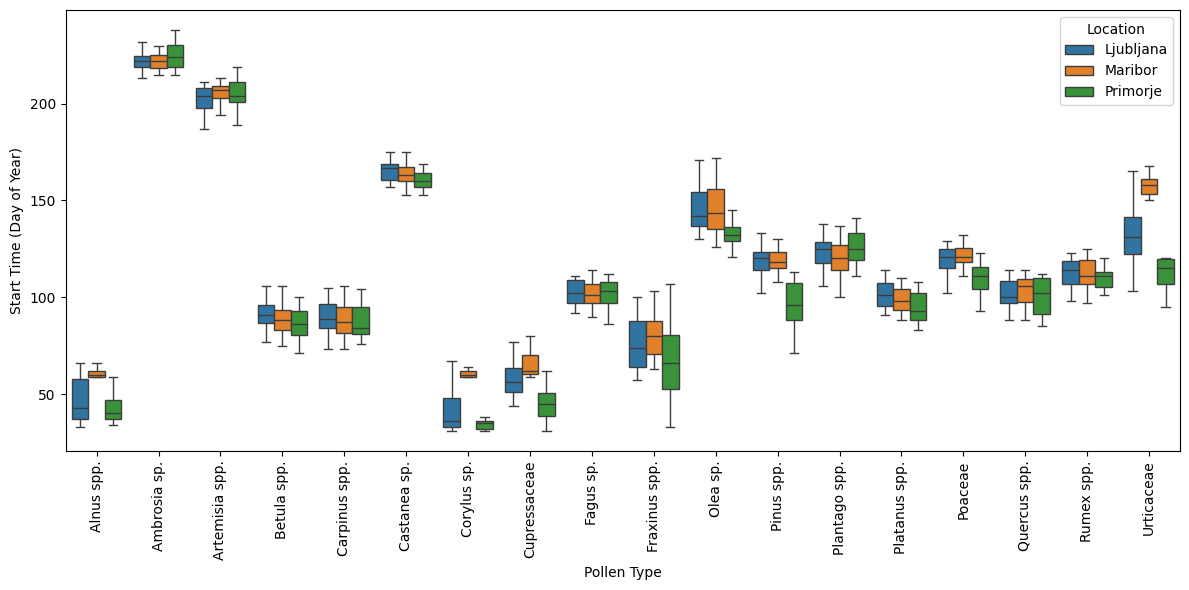

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
0,Alnus spp.,Ljubljana vs Maribor,1.900939e-06,1.026507e-04,True
2,Alnus spp.,Maribor vs Primorje,1.320472e-08,7.130548e-07,True
18,Corylus sp.,Ljubljana vs Maribor,8.100352e-08,4.374190e-06,True
20,Corylus sp.,Maribor vs Primorje,7.935869e-09,4.285369e-07,True
22,Cupressaceae,Ljubljana vs Primorje,6.725396e-04,3.631714e-02,True
23,Cupressaceae,Maribor vs Primorje,2.325206e-06,1.255611e-04,True
31,Olea sp.,Ljubljana vs Primorje,4.138341e-04,2.234704e-02,True
34,Pinus spp.,Ljubljana vs Primorje,1.983322e-05,1.070994e-03,True
35,Pinus spp.,Maribor vs Primorje,8.945882e-06,4.830776e-04,True
44,Poaceae,Maribor vs Primorje,1.305857e-04,7.051627e-03,True


-------------------- Mann-Whitney U Test Results --------------------


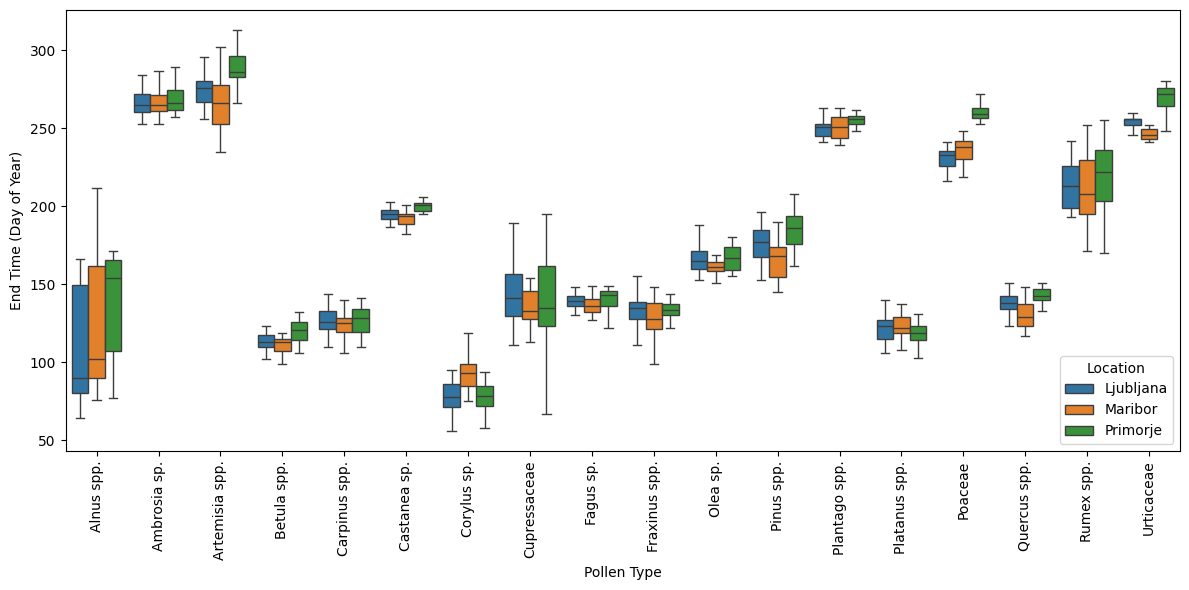

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
7,Artemisia spp.,Ljubljana vs Primorje,2.505378e-04,1.352904e-02,True
8,Artemisia spp.,Maribor vs Primorje,2.091958e-05,1.129657e-03,True
11,Betula spp.,Maribor vs Primorje,1.386126e-04,7.485079e-03,True
17,Castanea sp.,Maribor vs Primorje,1.967114e-04,1.062241e-02,True
18,Corylus sp.,Ljubljana vs Maribor,6.909879e-05,3.731335e-03,True
20,Corylus sp.,Maribor vs Primorje,4.102372e-05,2.215281e-03,True
35,Pinus spp.,Maribor vs Primorje,5.446809e-05,2.941277e-03,True
43,Poaceae,Ljubljana vs Primorje,6.475845e-09,3.496957e-07,True
44,Poaceae,Maribor vs Primorje,9.598636e-09,5.183263e-07,True
47,Quercus spp.,Maribor vs Primorje,1.340751e-04,7.240053e-03,True


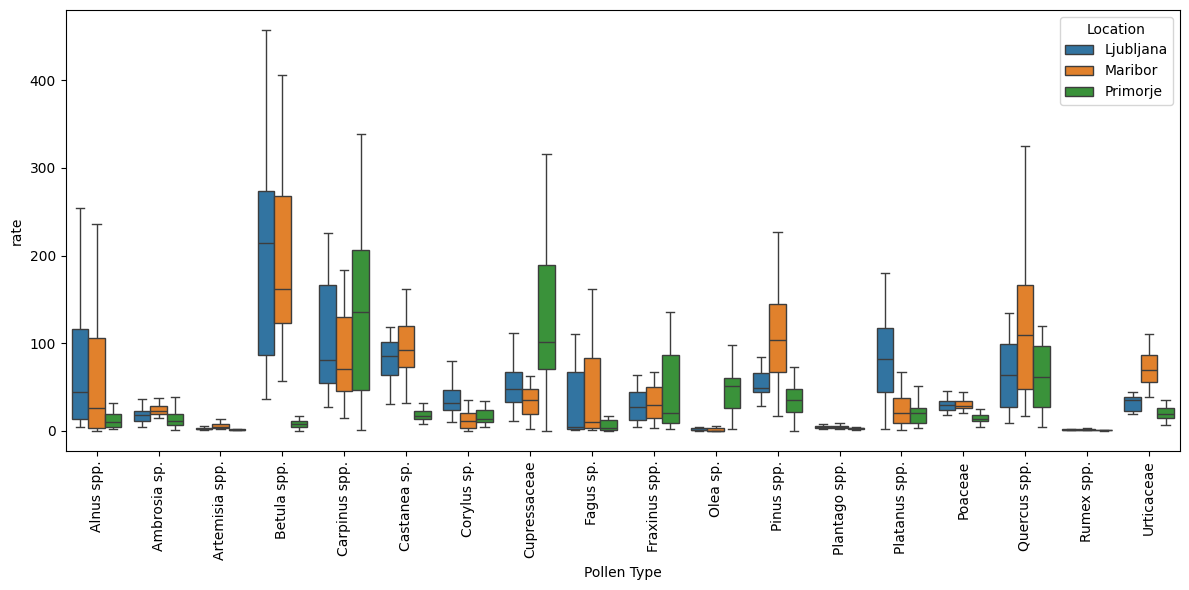

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
5,Ambrosia sp.,Maribor vs Primorje,6.098573e-04,3.293230e-02,True
7,Artemisia spp.,Ljubljana vs Primorje,3.423125e-04,1.848488e-02,True
8,Artemisia spp.,Maribor vs Primorje,1.192951e-07,6.441938e-06,True
10,Betula spp.,Ljubljana vs Primorje,9.854764e-09,5.321572e-07,True
11,Betula spp.,Maribor vs Primorje,9.854764e-09,5.321572e-07,True
16,Castanea sp.,Ljubljana vs Primorje,2.831258e-08,1.528879e-06,True
17,Castanea sp.,Maribor vs Primorje,2.831258e-08,1.528879e-06,True
18,Corylus sp.,Ljubljana vs Maribor,2.049857e-04,1.106923e-02,True
19,Corylus sp.,Ljubljana vs Primorje,4.514157e-04,2.437645e-02,True
22,Cupressaceae,Ljubljana vs Primorje,4.046413e-04,2.185063e-02,True


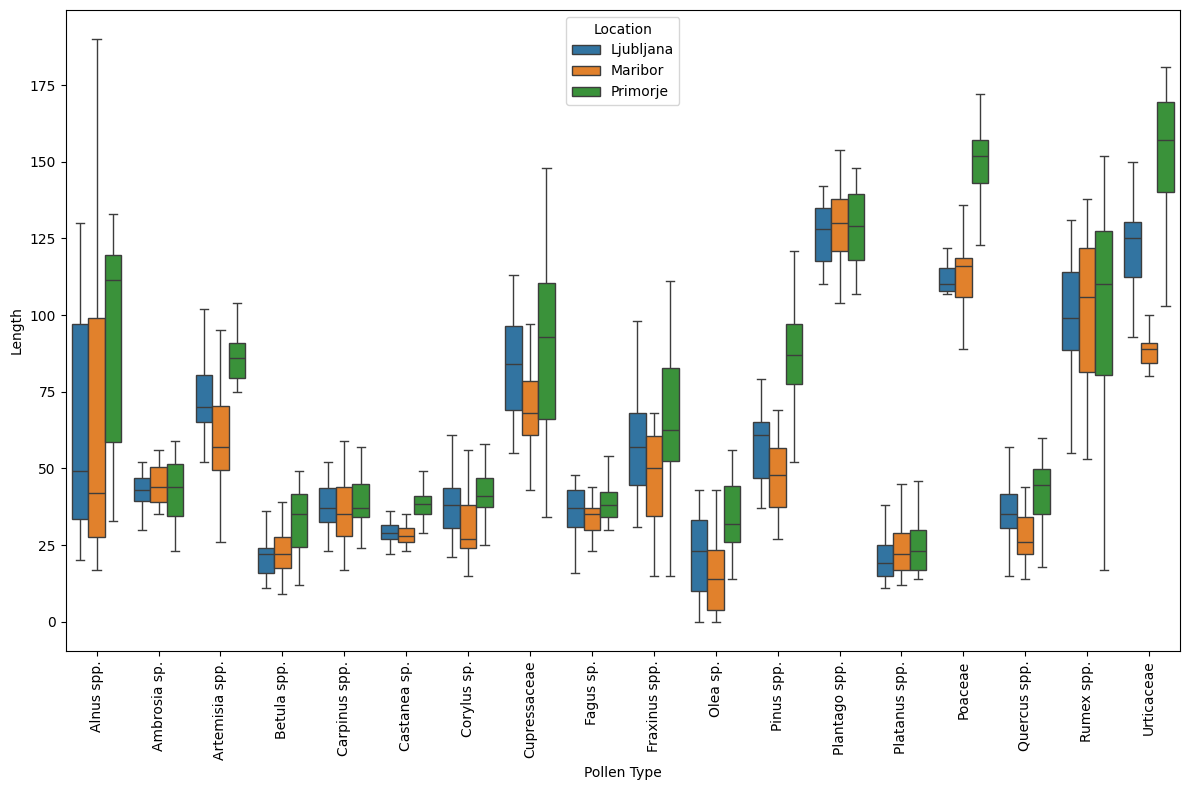

,Pollen,Comparison,p-value,corrected p-value,significant (Bonferroni)
8,Artemisia spp.,Maribor vs Primorje,3.956395e-05,0.002136,True
10,Betula spp.,Ljubljana vs Primorje,2.508171e-04,0.013544,True
11,Betula spp.,Maribor vs Primorje,6.760607e-04,0.036507,True
16,Castanea sp.,Ljubljana vs Primorje,6.721588e-07,0.000036,True
17,Castanea sp.,Maribor vs Primorje,2.600298e-07,0.000014,True
32,Olea sp.,Maribor vs Primorje,5.236127e-04,0.028275,True
34,Pinus spp.,Ljubljana vs Primorje,2.703401e-06,0.000146,True
35,Pinus spp.,Maribor vs Primorje,1.044319e-07,0.000006,True
43,Poaceae,Ljubljana vs Primorje,1.895886e-07,0.000010,True
44,Poaceae,Maribor vs Primorje,2.701443e-07,0.000015,True


In [3]:
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 6))


sns.boxplot(data=combined_df, x="Pollen taxa", y="Start", hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel("Start Time (Day of Year)")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


from scipy.stats import mannwhitneyu
import itertools
import statsmodels.stats.multitest as smm


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Pollen taxa", "Year", "Start", "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Pollen taxa"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Pollen taxa"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1]["Start"].values
        group2 = data_subset[data_subset["Location"] == loc2]["Start"].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}:")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
significant_results.head(20)
display(significant_results.head(20))
print(f"{20*'-'} Mann-Whitney U Test Results {20*'-'}")
### ---------------------------------------------------- ###

var = "End"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Pollen taxa", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 6))


sns.boxplot(data=combined_df, x="Pollen taxa", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel("End Time (Day of Year)")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Pollen taxa", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Pollen taxa"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Pollen taxa"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))


### ---------------------------------------------------- ###

var = "rate"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Pollen taxa", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 6))


sns.boxplot(data=combined_df, x="Pollen taxa", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel(f"{var}")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Pollen taxa", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Pollen taxa"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Pollen taxa"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))

### ---------------------------------------------------- ###

var = "Length"
data_all = []

for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    # Append only relevant columns
    data_all.append(df[["Pollen taxa", "Year", var, "Location"]])

# Combine all into one DataFrame
combined_df = pd.concat(data_all, ignore_index=True)
# Now create a boxplot for all pollen types, grouped by location
plt.figure(figsize=(12, 8))


sns.boxplot(data=combined_df, x="Pollen taxa", y=var, hue="Location", showfliers=False)
#plt.title("Distribution of Pollen Season Start Times (K10) Across Locations")
plt.xticks(rotation=90)
plt.ylabel(f"{var}")
plt.xlabel("Pollen Type")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


data_all = []
for location, filepath in files.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    df = pd.DataFrame(content)
    df["Location"] = location
    data_all.append(df[["Pollen taxa", "Year", var, "Location"]])

combined_df = pd.concat(data_all, ignore_index=True)

# Get pollen types and location pairs
pollen_types = combined_df["Pollen taxa"].unique()
location_pairs = list(itertools.combinations(combined_df["Location"].unique(), 2))

# Store results
results = []

for pollen in pollen_types:
    data_subset = combined_df[combined_df["Pollen taxa"] == pollen]
    for loc1, loc2 in location_pairs:
        group1 = data_subset[data_subset["Location"] == loc1][var].values
        group2 = data_subset[data_subset["Location"] == loc2][var].values
        #print(f"Comparing {pollen} between {loc1} and {loc2}")
        if len(group1) > 0 and len(group2) > 0:
            stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")
            results.append({"Pollen": pollen, "Comparison": f"{loc1} vs {loc2}", "p-value": p_value})

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Apply Bonferroni correction for multiple testing
rejected, corrected_p, _, _ = smm.multipletests(results_df["p-value"], method="bonferroni")
results_df["corrected p-value"] = corrected_p
results_df["significant (Bonferroni)"] = rejected

# Show only significant results
significant_results = results_df[results_df["significant (Bonferroni)"]]
display(significant_results.head(20))

In [5]:
import pandas as pd
import json

# Load summary files with CP (APIn) values
files_summary = {
    "Ljubljana": os.path.join("results","Ljubljana_results_norm.json"),
    "Maribor": os.path.join("results","Maribor_results_norm.json"),
    "Primorje": os.path.join("results","Primorje_results_norm.json")
}

apin_data = []
# Extract CP info for each pollen type and location
for location, filepath in files_summary.items():
    with open(filepath, "r", encoding="utf-8") as f:
        content = json.load(f)
    for pollen, values in content.items():
        if "CP" in values:
            apin_data.append({
                "Location": location,
                "Pollen": pollen,
                "Trend": values["CP"].get("Trend", None),
                "Intercept": values["CP"].get("Intercept", None),
                "P-value": values["CP"].get("P_Value", None),
                "STD-value": values["CP"].get("Std_Error", None),
                "R2": values["CP"].get("R2", None),
                "min_CP": values["CP"].get("min", None),
                "avg_CP": values["CP"].get("avg", None),
                "max_CP": values["CP"].get("max", None)
            })
print(f"{20*'-'} APIn Summary Data {20*'-'}")
apin_df = pd.DataFrame(apin_data)
apin_df = apin_df.sort_values(by=["R2"], ascending=False)
# Show the first rows to inspect
display(apin_df.head(10))
apin_df.to_excel("apin_summary_CP.xlsx", index=False)

for var in ["Start", "End", "Length"]:
    apin_data = []
    for location, filepath in files_summary.items():
        with open(filepath, "r", encoding="utf-8") as f:
            content = json.load(f)
        #print(f"Processing {location} for variable {var}...")
        for pollen, values in content.items():
            #print(f"Processing pollen type: {pollen, var, values}")
            if var in values:
                apin_data.append({
                    "Location": location,
                    "Pollen": pollen,
                    "Trend": values[var].get("Trend", None),
                    "Intercept": values[var].get("Intercept", None),
                    "P-value": values[var].get("P_Value", None),
                    "STD-value": values[var].get("Std_Error", None),
                    "R2": values[var].get("R2", None),
                    "min": values[var].get("min", None),
                    "avg": values[var].get("avg", None),
                    "max": values[var].get("max", None)
                })
    print(f"{20*'-'} {var} Summary Data {20*'-'}")
    apin_df = pd.DataFrame(apin_data)
    apin_df = apin_df.sort_values(by=["R2"], ascending=False)
    # Show the first rows to inspect
    display(apin_df.head(10))
    apin_df.to_excel(f"apin_summary_{var}.xlsx", index=False)

-------------------- APIn Summary Data --------------------


,Location,Pollen,Trend,Intercept,P-value,STD-value,R2,min_CP,avg_CP,max_CP
53,Primorje,Urticaceae,182.375494,-363791.173913,0.000057,36.315421,0.545654,1229.0,3330.695652,7478.0
30,Maribor,Plantago spp.,29.526680,-58805.684783,0.000059,5.894530,0.544387,251.0,631.521739,1413.0
32,Maribor,Poaceae,97.895257,-193393.456522,0.000082,20.105399,0.530287,2621.0,3669.695652,5583.0
20,Maribor,Artemisia spp.,-14.335968,29168.000000,0.000125,3.057719,0.511419,140.0,309.695652,594.0
25,Maribor,Cupressaceae,94.970356,-188837.282609,0.000157,20.667920,0.501360,204.0,2338.043478,3949.0
35,Maribor,Urticaceae,200.178854,-396319.510870,0.000172,43.938598,0.497078,3678.0,6640.521739,10688.0
2,Ljubljana,Artemisia spp.,-10.174901,20694.945652,0.000234,2.298225,0.482770,89.0,212.869565,468.0
7,Ljubljana,Cupressaceae,239.383399,-477244.695652,0.000256,54.536195,0.478484,1792.0,4634.086957,11646.0
17,Ljubljana,Urticaceae,114.865613,-227159.043478,0.000389,27.253641,0.458255,2361.0,4065.434783,5900.0
16,Ljubljana,Rumex spp.,-4.686759,9556.358696,0.000460,1.130954,0.449878,43.0,121.913043,210.0


-------------------- Start Summary Data --------------------


,Location,Pollen,Trend,Intercept,P-value,STD-value,R2,min,avg,max
49,Primorje,Platanus spp.,-0.652332,1408.226509,0.005411,0.207854,0.341414,83.0,95.238095,108.0
17,Ljubljana,Urticaceae,-1.412055,2975.336957,0.004026,0.437340,0.331737,103.0,132.869565,165.0
40,Primorje,Carpinus spp.,-0.781346,1659.647483,0.019428,0.307434,0.244121,57.0,86.727273,104.0
26,Maribor,Fagus sp.,-0.434783,977.391304,0.020710,0.173807,0.229573,90.0,102.173913,114.0
13,Ljubljana,Platanus spp.,-0.516798,1141.706522,0.025334,0.214652,0.216319,91.0,101.391304,114.0
4,Ljubljana,Carpinus spp.,-0.624506,1347.000000,0.027363,0.263352,0.211220,73.0,89.869565,105.0
7,Ljubljana,Cupressaceae,-0.639328,1344.489130,0.029224,0.273190,0.206850,44.0,57.521739,77.0
6,Ljubljana,Corylus sp.,-0.690711,1431.358696,0.032424,0.301523,0.199924,31.0,40.956522,67.0
11,Ljubljana,Pinus spp.,-0.578063,1281.293478,0.039975,0.263989,0.185886,89.0,117.652174,133.0
15,Ljubljana,Quercus spp.,-0.485178,1078.619565,0.044107,0.226548,0.179255,88.0,101.956522,114.0


-------------------- End Summary Data --------------------


,Location,Pollen,Trend,Intercept,P-value,STD-value,R2,min,avg,max
32,Maribor,Poaceae,0.832016,-1438.934783,0.000535,0.203867,0.442320,219.0,235.913043,248.0
20,Maribor,Artemisia spp.,1.637352,-3030.945652,0.001732,0.456351,0.380040,235.0,265.043478,302.0
4,Ljubljana,Carpinus spp.,-0.745059,1627.152174,0.002266,0.214460,0.364974,110.0,127.347826,144.0
50,Primorje,Poaceae,0.747036,-1242.739130,0.003797,0.229587,0.335177,246.0,261.043478,289.0
28,Maribor,Olea sp.,-0.835681,1841.556338,0.013247,0.300075,0.326477,126.0,160.166667,174.0
13,Ljubljana,Platanus spp.,-0.692688,1516.989130,0.016762,0.266548,0.243337,106.0,122.608696,140.0
0,Ljubljana,Alnus spp.,-2.703557,5550.565217,0.017006,1.042977,0.242404,64.0,108.304348,166.0
46,Primorje,Olea sp.,-0.552499,1279.139094,0.024894,0.227822,0.227240,155.0,166.909091,180.0
7,Ljubljana,Cupressaceae,-2.950593,6089.282609,0.021616,1.188952,0.226768,111.0,149.739130,317.0
42,Primorje,Corylus sp.,-0.683024,1452.670485,0.029313,0.290978,0.215993,58.0,77.681818,94.0


-------------------- Length Summary Data --------------------


,Location,Pollen,Trend,Intercept,P-value,STD-value,R2,min,avg,max
32,Maribor,Poaceae,1.145257,-2190.836957,0.000393,0.271999,0.457763,89.0,114.565217,138.0
20,Maribor,Artemisia spp.,1.643281,-3247.836957,0.000676,0.412551,0.430370,26.0,60.086957,95.0
17,Ljubljana,Urticaceae,1.457510,-2812.402174,0.002162,0.417132,0.367639,93.0,121.565217,150.0
14,Ljubljana,Poaceae,0.830040,-1559.869565,0.011447,0.299536,0.267755,84.0,111.000000,134.0
46,Primorje,Olea sp.,-0.904925,1855.696554,0.016950,0.347407,0.253312,14.0,34.000000,56.0
35,Maribor,Urticaceae,0.373518,-663.195652,0.025867,0.155772,0.214943,80.0,88.695652,101.0
0,Ljubljana,Alnus spp.,-2.052372,4193.554348,0.066791,1.061577,0.151095,20.0,62.130435,130.0
11,Ljubljana,Pinus spp.,0.643281,-1237.010870,0.084775,0.355581,0.134836,37.0,57.913043,79.0
7,Ljubljana,Cupressaceae,-2.311265,4744.793478,0.086314,1.284341,0.133608,55.0,92.217391,266.0
45,Primorje,Fraxinus spp.,1.208281,-2368.242558,0.101738,0.704402,0.128250,15.0,64.136364,111.0
